# ARTG Truck Processing Time Prediction - MODELING

---

**✅ CONFIGURATION:**
- ✅ Dataset: `dataset_final2bulan_45FEATURES_PROPER.csv`
- ✅ Outlier removal: Q5-Q99
- ✅ Expected MAE: 5-6 minutes

---

**📊 Dataset Info:**
- Samples: ~96,000 records
- Features: 45 features
- Target: GATE_IN_STACK (waktu processing truck)
- Period: 2 bulan (Oktober - Desember 2025)
- Outlier range: Q5-Q99 (7.35 - 70.83 menit)


## Ringkasan Alur 


Tujuan notebook ini: memakai data historis gate-in truk untuk memprediksi berapa menit durasi proses akan berlangsung. 


1) Ambil & cek data
- Muat dataset 2 bulan (~96k baris, 45 fitur, target: waktu GATE_IN_STACK).


2) Rapikan data kategorikal
- Bersihkan teks (buang spasi/“.0”) pada kolom lokasi, slot, tier, dan shift supaya penamaan konsisten antara training dan produksi.


3) Validasi kualitas target
- Hitung statistik dasar (rata-rata, median, minimum, maksimum) waktu proses untuk memastikan angkanya masuk akal dan tidak ada nilai ekstrim aneh.


4) Siapkan fitur
- Pisah fitur kategorikal (8 kolom seperti jenis job, ukuran kontainer, shift) dan numerik (37 kolom seperti jarak, kepadatan, histori durasi, encoding target).
- Cek semua fitur wajib ada sebelum lanjut.


5) Skala fitur jarak
- Fitur jarak memiliki rentang besar; disusutkan ke skala 0-1 agar model adil menilai semua fitur. Scaler ini disimpan untuk dipakai saat produksi.


6) Gunakan shift 8-bin
- Memakai pembagian shift 3-jam (shift_1…shift_8) sesuai data yang tersedia, lalu cek distribusinya.


7) Bagi data untuk pengujian adil
- Bagi 80% data untuk belajar, 20% untuk tes; isi kosong dengan 0 agar model tidak gagal karena nilai hilang.


8) Ubah teks jadi angka
- Encode 8 kolom kategorikal menjadi angka konsisten (label encoding) supaya model dapat menghitungnya; encoder disimpan untuk produksi.


9) Cari setelan model terbaik (tuning)
- Pakai Optuna (50 percobaan per model) untuk tiga algoritma: LightGBM, XGBoost, CatBoost. Tujuannya menurunkan MAE (rata-rata selisih absolut).


10) Latih & bandingkan model
- Latih model-model terbaik hasil tuning plus Random Forest, Gradient Boosting, dan dua ensemble (Stacking, Voting).
- Hitung MAE, RMSE, dan R² di data tes; pilih model dengan MAE terendah.


11) Cek metrik praktis
- Hitung berapa persen prediksi yang meleset ≤5 menit dan ≤10 menit, serta bandingkan dengan baseline dan model versi sebelumnya.


12) Simpan untuk produksi
- Simpan model terbaik, semua model, encoder, daftar fitur, scaler, dan metadata (kinerja, fitur, versi) ke folder models/ agar bisa dipakai API/servis produksi.


Intinya: data historis dibersihkan, dinormalisasi, dipecah train/test, dikonversi ke angka, lalu beberapa algoritma dicoba dan dibandingkan. Model dengan kesalahan rata-rata paling kecil dipilih dan disimpan bersama alat bantu (encoder/scaler) supaya prediksi di lapangan konsisten dengan proses training.

## Bagaimana Model “Belajar”

Bayangkan kita ingin bikin rumus otomatis yang menebak lama proses gate-in. Rumusnya tidak ditulis manual, tapi “disusun” oleh komputer dari pola data historis. Model terbaik di sini adalah model boosting (contoh LightGBM/XGBoost/CatBoost) yang belajar bertahap dari kesalahan.

1) Tujuan yang dikejar: mengecilkan selisih absolut rata-rata
- Model meminimalkan MAE (Mean Absolute Error):
- $\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$
- Artinya: rata-rata selisih menit antara waktu nyata $(y_i)$ dan prediksi $(\hat{y}_i)$ sekecil mungkin.

2) Cara boosting menyusun “rumus” bertahap
- Prediksi akhir adalah penjumlahan banyak pohon keputusan kecil (tree) yang belajar memperbaiki sisa error:
- $\hat{y}(x) = \sum_{t=1}^{T} \eta_t \cdot f_t(x)$
- $f_t(x)$ = pohon kecil ke-$t$; $\eta_t$ = bobot (learning rate).
- Intinya: pohon pertama bikin prediksi awal, pohon kedua belajar dari kesalahan pohon pertama, pohon ketiga belajar dari sisa kesalahan sebelumnya, dan seterusnya.

3) Bagaimana pohon kecil memutuskan split
- Tiap pohon memilih pertanyaan sederhana, misal “apakah jarak > 0.6?” atau “shift dalam {shift_7, shift_8}?”, untuk memecah data.
- Pilihan split dipilih yang paling mengurangi error lokal (mis. mengurangi selisih absolut di cabang tersebut).

4) Kenapa butuh scaling & encoding
- Fitur jarak dibawa ke skala 0-1 agar tidak mendominasi fitur lain.
- Kolom kategori diubah ke angka dengan label encoding agar pohon bisa membelah data berdasar nilai kategori.

5) Ringkas untuk present:
- Kita punya fungsi prediksi yang otomatis dibentuk dari data historis.
- Fungsi itu = penjumlahan banyak aturan kecil (pohon) yang dilatih untuk mengecilkan selisih menit antara prediksi dan realitas.
- Targetnya jelas: MAE serendah mungkin, supaya prediksi mendekati waktu nyata.
- Semua alat bantu (encoder, scaler, model) disimpan, sehingga rumus yang sama dipakai di produksi (konsisten antara training dan operasional).

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    StackingRegressor,
    VotingRegressor
)
from sklearn.linear_model import Ridge

# Hyperparameter tuning
import optuna
from optuna.samplers import TPESampler

# Utils
import joblib
import json
import os

# Constants
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Load Dataset

In [2]:
dataset_path = '../Data/processed/dataset_final2bulan_45FEATURES_PROPER.csv'

df = pd.read_csv(dataset_path)

print(f"Dataset loaded")
print(f"Shape: {df.shape}")
print(f"Rows: {len(df):,}")
print(f"Columns: {df.shape[1]}")

Dataset loaded
Shape: (96496, 46)
Rows: 96,496
Columns: 46


In [3]:
# Preview data
print("\n" + "="*80)
print("DATASET PREVIEW")
print("="*80)
print("\nFirst 5 rows:")
display(df.head())

print("\nColumn names:")
print(df.columns.tolist())

print(f"\n📊 Dataset info:")
print(f"   Features: {df.shape[1] - 1}")
print(f"   Target: GATE_IN_STACK")


DATASET PREVIEW

First 5 rows:


,JOB_TYPE,CONTAINER_SIZE,CTR_STATUS,CONTAINER_TYPE,slot,tier,block,gate_in_shift,gate_in_hour,gate_in_dayofweek,...,congestion_tier,rush_hour_congestion,slot_duration_std,slot_duration_min,slot_duration_max,prev_duration_same_location,rolling_mean_3,BLOCK_target_enc,LOKASI_target_enc,GATE_IN_STACK
0,Receiving,20,FCL,DRY,1.0,1.0,2C,shift_6,17,1,...,26,0,9.516181,7.37,54.6,17.486556,17.486556,21.779954,16.224,7.45
1,Delivery,20,MTY,DRY,1.0,1.0,D1,shift_4,10,0,...,23,23,9.516181,7.37,54.6,7.450000,7.450000,25.843113,16.224,24.27
2,Receiving,20,MTY,DRY,1.0,1.0,D1,shift_8,22,2,...,9,0,9.516181,7.37,54.6,24.270000,15.860000,25.843113,16.224,19.20
3,Receiving,20,MTY,DRY,1.0,1.0,4A,shift_1,0,0,...,5,0,9.516181,7.37,54.6,19.200000,16.973333,17.485271,16.224,24.12
4,Receiving,20,FCL,DRY,1.0,1.0,D1,shift_6,16,1,...,18,0,9.516181,7.37,54.6,24.120000,22.530000,25.843113,16.224,17.22



Column names:
['JOB_TYPE', 'CONTAINER_SIZE', 'CTR_STATUS', 'CONTAINER_TYPE', 'slot', 'tier', 'block', 'gate_in_shift', 'gate_in_hour', 'gate_in_dayofweek', 'gate_in_day', 'gate_in_month', 'gate_in_is_weekend', 'gate_in_is_peak', 'slot_numeric', 'row_numeric', 'tier_numeric', 'block_numeric', 'distance_from_gate', 'vertical_distance', 'hourly_volume', 'congestion_count', 'slot_historical_avg', 'tier_historical_avg', 'lokasi_historical_avg', 'hour_historical_avg', 'container_size_numeric', 'is_empty', 'is_full', 'is_reefer', 'is_special', 'is_morning_rush', 'is_afternoon_rush', 'is_rush_hour', 'slot_tier_interaction', 'size_tier_interaction', 'congestion_tier', 'rush_hour_congestion', 'slot_duration_std', 'slot_duration_min', 'slot_duration_max', 'prev_duration_same_location', 'rolling_mean_3', 'BLOCK_target_enc', 'LOKASI_target_enc', 'GATE_IN_STACK']

📊 Dataset info:
   Features: 45
   Target: GATE_IN_STACK


In [4]:
print("\n2. 🔧 CRITICAL FIX: Cleaning categorical features...")

def clean_categorical_value(value):
    """
    Clean categorical values for consistency
    - Convert to string
    - Strip whitespace
    - Remove .0 decimal (e.g., '1.0' -> '1')
    """
    s = str(value).strip()
    
    # Remove .0 if present
    if s.endswith('.0'):
        s = s[:-2]
    
    return s

# Categorical features to clean
categorical_cols = ['slot', 'tier', 'block', 'gate_in_shift']

print(f"\n   Cleaning {len(categorical_cols)} categorical columns...")

for col in categorical_cols:
    if col in df.columns:
        print(f"\n   {col}:")
        print(f"      Before: {df[col].unique()[:5]}")
        
        # Apply cleaning
        df[col] = df[col].apply(clean_categorical_value)
        
        print(f"      After:  {df[col].unique()[:5]}")
        print(f"      Unique values: {df[col].nunique()}")

print("\n✅ Categorical features cleaned!")
print("   This ensures encoder training matches production usage!")


2. 🔧 CRITICAL FIX: Cleaning categorical features...

   Cleaning 4 categorical columns...

   slot:
      Before: [  1.  10. 102.  11.  12.]
      After:  ['1' '10' '102' '11' '12']
      Unique values: 100

   tier:
      Before: [1. 2. 3. 4. 5.]
      After:  ['1' '2' '3' '4' '5']
      Unique values: 7

   block:
      Before: ['2C' 'D1' '4A' '6C' '1A']
      After:  ['2C' 'D1' '4A' '6C' '1A']
      Unique values: 24

   gate_in_shift:
      Before: ['shift_6' 'shift_4' 'shift_8' 'shift_1' 'shift_5']
      After:  ['shift_6' 'shift_4' 'shift_8' 'shift_1' 'shift_5']
      Unique values: 8

✅ Categorical features cleaned!
   This ensures encoder training matches production usage!


## 3. Dataset Validation

In [5]:
print("="*80)
print("DATASET VALIDATION")
print("="*80)

# Target variable stats
print(f"\n📊 Target Variable: GATE_IN_STACK")
print(f"   Mean:   {df['GATE_IN_STACK'].mean():.2f} minutes")
print(f"   Median: {df['GATE_IN_STACK'].median():.2f} minutes")
print(f"   Std:    {df['GATE_IN_STACK'].std():.2f} minutes")
print(f"   Min:    {df['GATE_IN_STACK'].min():.2f} minutes")
print(f"   Max:    {df['GATE_IN_STACK'].max():.2f} minutes")
print(f"   Q25:    {df['GATE_IN_STACK'].quantile(0.25):.2f} minutes")
print(f"   Q75:    {df['GATE_IN_STACK'].quantile(0.75):.2f} minutes")

# Verify categorical features have no trailing spaces
print(f"\n🔍 BLOCK VALUE CHECK (Critical!):")
sample_blocks = df['block'].unique()[:5]
print(f"   Sample blocks: {sample_blocks.tolist()}")
for block in sample_blocks:
    has_space = block != block.strip()
    print(f"   '{block}' -> Trailing space: {'❌ YES!' if has_space else '✅ NO'}")

# Verify shift values
print(f"\n🔍 SHIFT VALUE CHECK:")
print(f"   Unique shifts: {sorted(df['gate_in_shift'].unique())}")
print(f"   Expected: ['shift_1', 'shift_2', ..., 'shift_8']")

DATASET VALIDATION

📊 Target Variable: GATE_IN_STACK
   Mean:   17.49 minutes
   Median: 13.70 minutes
   Std:    10.52 minutes
   Min:    7.35 minutes
   Max:    70.83 minutes
   Q25:    10.65 minutes
   Q75:    20.40 minutes

🔍 BLOCK VALUE CHECK (Critical!):
   Sample blocks: ['2C', 'D1', '4A', '6C', '1A']
   '2C' -> Trailing space: ✅ NO
   'D1' -> Trailing space: ✅ NO
   '4A' -> Trailing space: ✅ NO
   '6C' -> Trailing space: ✅ NO
   '1A' -> Trailing space: ✅ NO

🔍 SHIFT VALUE CHECK:
   Unique shifts: ['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6', 'shift_7', 'shift_8']
   Expected: ['shift_1', 'shift_2', ..., 'shift_8']


In [6]:
print("\n3. Verifying columns...")

required_cols = [
    'JOB_TYPE', 'CONTAINER_SIZE', 'CTR_STATUS', 'CONTAINER_TYPE',
    'slot', 'tier', 'block', 'gate_in_shift',
    'GATE_IN_STACK'
]

missing = [col for col in required_cols if col not in df.columns]
if missing:
    print(f"❌ Missing columns: {missing}")
    exit(1)

print(f"✅ All required columns present")


3. Verifying columns...
✅ All required columns present


## 4. Feature Preparation 

In [7]:
# Target variable
target_col = 'GATE_IN_STACK'

# Categorical features (8 total)
categorical_features = [
    'JOB_TYPE',
    'CONTAINER_SIZE',
    'CTR_STATUS',
    'CONTAINER_TYPE',
    'slot',
    'tier',
    'block',
    'gate_in_shift'  
]

# Numerical features (37 total)
numerical_features = [
    # Temporal (6)
    'gate_in_hour',
    'gate_in_dayofweek',
    'gate_in_day',
    'gate_in_month',
    'gate_in_is_weekend',
    'gate_in_is_peak',
    
    # Location/Distance (6)
    'slot_numeric',
    'row_numeric',
    'tier_numeric',
    'block_numeric',
    'distance_from_gate',
    'vertical_distance',
    
    # Congestion (2)
    'congestion_count',
    'hourly_volume',
    
    # Historical (4)
    'slot_historical_avg',
    'tier_historical_avg',
    'lokasi_historical_avg',
    'hour_historical_avg',
    
    # Container (5)
    'container_size_numeric',
    'is_empty',
    'is_full',
    'is_reefer',
    'is_special',
    
    # Rush hour (3)
    'is_morning_rush',
    'is_afternoon_rush',
    'is_rush_hour',
    
    # Interactions (4)
    'slot_tier_interaction',
    'size_tier_interaction',
    'congestion_tier',
    'rush_hour_congestion',
    
    # Statistical (3)
    'slot_duration_std',
    'slot_duration_min',
    'slot_duration_max',
    
    # Lag features (2)
    'prev_duration_same_location',
    'rolling_mean_3',
    
    # Target encoding (2)
    'BLOCK_target_enc',
    'LOKASI_target_enc'
]

# All features
all_features = categorical_features + numerical_features

print(f"   Categorical: {len(categorical_features)}")
print(f"   Numerical: {len(numerical_features)}")
print(f"   Total: {len(all_features)}")

# Verify all features exist
missing_features = [f for f in all_features if f not in df.columns]
if missing_features:
    print(f"❌ Missing features: {missing_features}")
    exit(1)

print(f"✅ All {len(all_features)} features present")

   Categorical: 8
   Numerical: 37
   Total: 45
✅ All 45 features present


## 5. Train-Test Split (80/20)

## 4.5. CRITICAL FIX: Scale Distance Features

**Problem:** Distance features have huge range (15-835) which causes models to ignore them in favor of lookup table values.

**Solution:** Apply MinMaxScaler to distance-related features so they're in 0-1 range.

In [8]:
from sklearn.preprocessing import MinMaxScaler

print("=" * 80)
print("🔧 SCALING DISTANCE FEATURES")
print("=" * 80)

# Distance-related features that need scaling
distance_features = [
    'distance_from_gate',
    'vertical_distance',
    'slot_numeric',
    'row_numeric',
    'tier_numeric',
    'slot_tier_interaction',
    'size_tier_interaction'
]

print(f"\nFeatures to scale: {len(distance_features)}")
for feat in distance_features:
    print(f"   {feat}: min={df[feat].min():.2f}, max={df[feat].max():.2f}")

# Apply MinMaxScaler
scaler = MinMaxScaler()
df[distance_features] = scaler.fit_transform(df[distance_features])

print(f"\n✅ Features scaled to [0, 1] range")
for feat in distance_features:
    print(f"   {feat}: min={df[feat].min():.2f}, max={df[feat].max():.2f}")

print(f"\nℹ️ Note: Scaler will be saved for production use")
print("=" * 80)

🔧 SCALING DISTANCE FEATURES

Features to scale: 7
   distance_from_gate: min=15.00, max=1029.00
   vertical_distance: min=1.00, max=49.00
   slot_numeric: min=1.00, max=102.00
   row_numeric: min=1.00, max=13.00
   tier_numeric: min=1.00, max=7.00
   slot_tier_interaction: min=1.00, max=420.00
   size_tier_interaction: min=20.00, max=280.00

✅ Features scaled to [0, 1] range
   distance_from_gate: min=0.00, max=1.00
   vertical_distance: min=0.00, max=1.00
   slot_numeric: min=0.00, max=1.00
   row_numeric: min=0.00, max=1.00
   tier_numeric: min=0.00, max=1.00
   slot_tier_interaction: min=0.00, max=1.00
   size_tier_interaction: min=0.00, max=1.00

ℹ️ Note: Scaler will be saved for production use


In [9]:
print("="*80)
print("🧪 SMOOTHING TARGET ENCODING (LOKASI)")
print("="*80)

# Global mean for smoothing
global_mean = df['GATE_IN_STACK'].mean()
blend_alpha = 0.3  # weight for existing value vs global mean (lower = more smoothing)

if 'LOKASI_target_enc' in df.columns:
    df['LOKASI_target_enc'] = blend_alpha * df['LOKASI_target_enc'] + (1 - blend_alpha) * global_mean
else:
    print("⚠️ LOKASI_target_enc not found; skipping")

if 'lokasi_historical_avg' in df.columns:
    df['lokasi_historical_avg'] = blend_alpha * df['lokasi_historical_avg'] + (1 - blend_alpha) * global_mean
else:
    print("⚠️ lokasi_historical_avg not found; skipping")

print(f"Global mean: {global_mean:.2f}")
print(f"Blend alpha: {blend_alpha}")
print("New stats (head):")
cols_to_show = [c for c in ['LOKASI_target_enc', 'lokasi_historical_avg'] if c in df.columns]
print(df[cols_to_show].head())
print("="*80)


🧪 SMOOTHING TARGET ENCODING (LOKASI)
Global mean: 17.49
Blend alpha: 0.3
New stats (head):
   LOKASI_target_enc  lokasi_historical_avg
0           17.10779               17.10779
1           17.10779               17.10779
2           17.10779               17.10779
3           17.10779               17.10779
4           17.10779               17.10779


## 4.6. SHIFT CONVERSION: 8-bin → 3-bin (like V1 model)

**Experiment:** Atasan minta 8 shift (3-jam), tapi model lama pakai 3 shift (night/day/evening) dan variance bagus.
Mari test apakah shift granularity mempengaruhi model variance.

In [10]:
print("="*80)
print("\ud83d\udd04 CONVERTING SHIFT: use gate_in_shift (8 bins)")
print("="*80)

# Use the existing 8-bin shift from dataset
# Dataset 2 bulan sudah memiliki gate_in_shift (shift_1 .. shift_8)
df['shift'] = df['gate_in_shift'].astype(str)

# Verify distribution
print("\nShift distribution (expected shift_1 .. shift_8):")
print(df['shift'].value_counts().sort_index())

print("\n\u2705 Shift set to 8-bin gate_in_shift and verified")
print("="*80)

Exception in callback BaseAsyncIOLoop._handle_events(924, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(924, 1)>
Traceback (most recent call last):
  File "C:\Users\ACER NITRO 5\AppData\Roaming\Python\Python312\site-packages\jupyter_client\session.py", line 100, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 110-111: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Anaconda3\Lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 202, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\ACER NITRO 5\AppData\Roaming\Python\Python312\site-packages\zmq\eventloop\zmqstream.py", line 610, in _handle_events
    self._handle_recv()
  File "C:\User

In [11]:
print("="*80)
print("TRAIN-TEST SPLIT")
print("="*80)

X = df[all_features].copy()
y = df[target_col].copy()

# Fill missing values
X = X.fillna(0)

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

print(f"✅ Split complete")
print(f"   Train: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test:  {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"   Train mean: {y_train.mean():.2f} minutes")
print(f"   Test mean:  {y_test.mean():.2f} minutes")

TRAIN-TEST SPLIT
✅ Split complete
   Train: 77,196 samples (80.0%)
   Test:  19,300 samples (20.0%)
   Train mean: 17.49 minutes
   Test mean:  17.45 minutes


## 6. Label Encoding (8 CATEGORICAL FEATURES)

In [12]:
print("="*80)
print("LABEL ENCODING (8 CATEGORICAL FEATURES)")
print("="*80)

label_encoders = {}

print(f"\n   Encoding {len(categorical_features)} features:\n")

for col in categorical_features:
    # Create encoder
    le = LabelEncoder()
    
    # Fit on ALL data (train + test) to ensure consistency
    le.fit(X[col].astype(str))
    
    # Transform train and test
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    
    # Store encoder
    label_encoders[col] = le
    
    print(f"   ✅ {col}: {len(le.classes_)} unique values")
    
    # Print first few classes for verification
    sample_classes = le.classes_[:5] if len(le.classes_) > 5 else le.classes_
    print(f"      Sample classes: {sample_classes.tolist()}")

print(f"\n✅ Encoding complete! Saved {len(label_encoders)} encoders")

LABEL ENCODING (8 CATEGORICAL FEATURES)

   Encoding 8 features:

   ✅ JOB_TYPE: 2 unique values
      Sample classes: ['Delivery', 'Receiving']
   ✅ CONTAINER_SIZE: 3 unique values
      Sample classes: ['20', '40', '45']
   ✅ CTR_STATUS: 2 unique values
      Sample classes: ['FCL', 'MTY']
   ✅ CONTAINER_TYPE: 6 unique values
      Sample classes: ['DRY', 'FLT', 'O/T', 'OVD', 'RFR']
   ✅ slot: 100 unique values
      Sample classes: ['1', '10', '102', '11', '12']
   ✅ tier: 7 unique values
      Sample classes: ['1', '2', '3', '4', '5']
   ✅ block: 24 unique values
      Sample classes: ['1A', '1B', '1C', '1D', '1E']
   ✅ gate_in_shift: 8 unique values
      Sample classes: ['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5']

✅ Encoding complete! Saved 8 encoders


In [13]:
print("="*80)
print("💾 SAVING LABEL ENCODERS (with 3-bin shift)")
print("="*80)

import joblib
import os

model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# Save label_encoders
joblib.dump(label_encoders, f'{model_dir}/label_encoders_2_bulan.pkl')
print(f"✅ Saved label_encoders_2_bulan.pkl")
print(f"   Encoders: {list(label_encoders.keys())}")
print(f"   Shift classes: {label_encoders['gate_in_shift'].classes_}")

print("="*80)

💾 SAVING LABEL ENCODERS (with 3-bin shift)
✅ Saved label_encoders_2_bulan.pkl
   Encoders: ['JOB_TYPE', 'CONTAINER_SIZE', 'CTR_STATUS', 'CONTAINER_TYPE', 'slot', 'tier', 'block', 'gate_in_shift']
   Shift classes: ['shift_1' 'shift_2' 'shift_3' 'shift_4' 'shift_5' 'shift_6' 'shift_7'
 'shift_8']


## 7. Hyperparameter Tuning with Optuna (FASTER: 50 trials)

In [14]:
print("Starting hyperparameter tuning with Optuna (50trials each)...\n")

# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ============================================================================
# LIGHTGBM TUNING
# ============================================================================
def objective_lgbm(trial):
    params = {
        'objective': 'regression', #Menentukan tujuan model sebagai 'regression' (regresi), artinya model akan memprediksi nilai numerik kontinyu, bukan klasifikasi.
        'metric': 'mae',
        'boosting_type': 'gbdt', #Gradient Boosting Decision Tree
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'n_estimators': 500,
        'random_state': RANDOM_STATE,
        'verbose': -1,
        'force_col_wise': True
    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)],
              callbacks=[lgb.early_stopping(50, verbose=False)])
    
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

print("Tuning LightGBM (50 trials)...")
study_lgbm = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE))
study_lgbm.optimize(objective_lgbm, n_trials=50
, show_progress_bar=True)

best_params_lgbm = study_lgbm.best_params
best_params_lgbm.update({
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'random_state': RANDOM_STATE,
    'verbose': -1,
    'force_col_wise': True
})

print(f"Best LightGBM MAE: {study_lgbm.best_value:.4f}")

# ============================================================================
# XGBOOST TUNING
# ============================================================================
def objective_xgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'n_estimators': 500,
        'random_state': RANDOM_STATE,
        'tree_method': 'hist',
        'verbosity': 0
    }
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)
    
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

print("\n Tuning XGBoost (50 trials)...")
study_xgb = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE))
study_xgb.optimize(objective_xgb, n_trials=50
, show_progress_bar=True)

best_params_xgb = study_xgb.best_params
best_params_xgb.update({
    'n_estimators': 500,
    'random_state': RANDOM_STATE,
    'tree_method': 'hist',
    'verbosity': 0
})

print(f"Best XGBoost MAE: {study_xgb.best_value:.4f}")

# ============================================================================
# CATBOOST TUNING
# ============================================================================
def objective_catboost(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'iterations': 500,
        'random_state': RANDOM_STATE,
        'verbose': False
    }
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=(X_test, y_test),
              early_stopping_rounds=50,
              verbose=False)
    
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

print("\n Tuning CatBoost (50trials)...")
study_catboost = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE))
study_catboost.optimize(objective_catboost, n_trials=50
, show_progress_bar=True)

best_params_catboost = study_catboost.best_params
best_params_catboost.update({
    'iterations': 500,
    'random_state': RANDOM_STATE,
    'verbose': False
})

print(f"Best CatBoost MAE: {study_catboost.best_value:.4f}")

print("\n" + "="*80)
print("HYPERPARAMETER TUNING COMPLETE (V2 - 50 trials each)!")
print("="*80)

Starting hyperparameter tuning with Optuna (50trials each)...

Tuning LightGBM (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

Best LightGBM MAE: 6.3677

 Tuning XGBoost (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

Best XGBoost MAE: 6.2925

 Tuning CatBoost (50trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

Best CatBoost MAE: 6.3006

HYPERPARAMETER TUNING COMPLETE (V2 - 50 trials each)!


In [15]:
print("Training models with optimized parameters...\n")

# Train LightGBM
print("Training LightGBM...")
lgbm_model = lgb.LGBMRegressor(**best_params_lgbm)
lgbm_model.fit(X_train, y_train,
               eval_set=[(X_test, y_test)],
               callbacks=[lgb.early_stopping(50, verbose=False)])

y_pred_lgbm = lgbm_model.predict(X_test)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)
print(f"LightGBM - MAE: {mae_lgbm:.4f}, RMSE: {rmse_lgbm:.4f}, R²: {r2_lgbm:.4f}\n")

# Train XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(**best_params_xgb)
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - MAE: {mae_xgb:.4f}, RMSE: {rmse_xgb:.4f}, R²: {r2_xgb:.4f}\n")

# Train CatBoost
print("Training CatBoost...")
catboost_model = CatBoostRegressor(**best_params_catboost)
catboost_model.fit(X_train, y_train,
                   eval_set=(X_test, y_test),
                   early_stopping_rounds=50,
                   verbose=False)

y_pred_catboost = catboost_model.predict(X_test)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)
print(f"CatBoost - MAE: {mae_catboost:.4f}, RMSE: {rmse_catboost:.4f}, R²: {r2_catboost:.4f}\n")

# Train Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}\n")

# Train Gradient Boosting
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=RANDOM_STATE
)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)
print(f"Gradient Boosting - MAE: {mae_gb:.4f}, RMSE: {rmse_gb:.4f}, R²: {r2_gb:.4f}\n")

Training models with optimized parameters...

Training LightGBM...
LightGBM - MAE: 6.3677, RMSE: 9.1507, R²: 0.2304

Training XGBoost...
XGBoost - MAE: 6.2925, RMSE: 9.0550, R²: 0.2465

Training CatBoost...
CatBoost - MAE: 6.3006, RMSE: 9.0592, R²: 0.2458

Training Random Forest...
Random Forest - MAE: 6.6796, RMSE: 9.5338, R²: 0.1647

Training Gradient Boosting...
Gradient Boosting - MAE: 6.6068, RMSE: 9.4648, R²: 0.1767



In [16]:
print("Creating ensemble with top 3 base models only...\n")

# Use only top 3 performers as base models
base_models = [
    ('lgbm', lgbm_model),
    ('xgb', xgb_model),
    ('catboost', catboost_model)
]

# Stacking
meta_model = Ridge(alpha=1.0)
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3,  # Reduced from 5
    n_jobs=-1
)

print("Training stacking model...")
stacking_model.fit(X_train, y_train)

y_pred_stacking = stacking_model.predict(X_test)
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
r2_stacking = r2_score(y_test, y_pred_stacking)
print(f"Stacking Ensemble - MAE: {mae_stacking:.4f}, RMSE: {rmse_stacking:.4f}, R²: {r2_stacking:.4f}\n")

# Voting
voting_model = VotingRegressor(estimators=base_models, n_jobs=-1)
voting_model.fit(X_train, y_train)

y_pred_voting = voting_model.predict(X_test)
mae_voting = mean_absolute_error(y_test, y_pred_voting)
rmse_voting = np.sqrt(mean_squared_error(y_test, y_pred_voting))
r2_voting = r2_score(y_test, y_pred_voting)
print(f"Voting Ensemble - MAE: {mae_voting:.4f}, RMSE: {rmse_voting:.4f}, R²: {r2_voting:.4f}\n")

Creating ensemble with top 3 base models only...

Training stacking model...
Stacking Ensemble - MAE: 6.2451, RMSE: 9.0024, R²: 0.2552

Voting Ensemble - MAE: 6.2803, RMSE: 9.0303, R²: 0.2506



In [17]:
# Compile results
results = pd.DataFrame({
    'Model': [
        'LightGBM (Tuned)',
        'XGBoost (Tuned)',
        'CatBoost (Tuned)',
        'Random Forest',
        'Gradient Boosting',
        'Stacking Ensemble',
        'Voting Ensemble'
    ],
    'MAE': [mae_lgbm, mae_xgb, mae_catboost, mae_rf, mae_gb, mae_stacking, mae_voting],
    'RMSE': [rmse_lgbm, rmse_xgb, rmse_catboost, rmse_rf, rmse_gb, rmse_stacking, rmse_voting],
    'R²': [r2_lgbm, r2_xgb, r2_catboost, r2_rf, r2_gb, r2_stacking, r2_voting]
})

results = results.sort_values('MAE').reset_index(drop=True)

print("\n" + "="*80)
print(" MODEL COMPARISON RESULTS")
print("="*80)
print(results.to_string(index=False))
print("="*80)

# Best model
best_idx = results['MAE'].idxmin()
best_model_name = results.loc[best_idx, 'Model']
best_mae = results.loc[best_idx, 'MAE']
best_rmse = results.loc[best_idx, 'RMSE']
best_r2 = results.loc[best_idx, 'R²']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   MAE:  {best_mae:.4f} minutes")
print(f"   RMSE: {best_rmse:.4f} minutes")
print(f"   R²:   {best_r2:.4f}")

# Compare with baseline and V1
baseline_mae = 7.77
v1_mae = 7.25  # From previous results

improvement_vs_baseline = ((baseline_mae - best_mae) / baseline_mae) * 100
improvement_vs_v1 = ((v1_mae - best_mae) / v1_mae) * 100

print(f"\n IMPROVEMENT COMPARISON:")
print(f"   Baseline MAE:     {baseline_mae:.2f} minutes")
print(f"   V1 MAE:           {v1_mae:.2f} minutes (6.7% better than baseline)")
print(f"   V2 MAE (current): {best_mae:.2f} minutes")
print(f"   ")
print(f"   V2 vs Baseline:   {improvement_vs_baseline:.1f}% improvement")
print(f"   V2 vs V1:         {improvement_vs_v1:.1f}% improvement")

# Practical metrics
if best_model_name == 'LightGBM (Tuned)':
    y_pred_best = y_pred_lgbm
elif best_model_name == 'XGBoost (Tuned)':
    y_pred_best = y_pred_xgb
elif best_model_name == 'CatBoost (Tuned)':
    y_pred_best = y_pred_catboost
elif best_model_name == 'Stacking Ensemble':
    y_pred_best = y_pred_stacking
elif best_model_name == 'Voting Ensemble':
    y_pred_best = y_pred_voting
else:
    y_pred_best = y_pred_rf

errors = np.abs(y_test - y_pred_best)
within_10min = (errors <= 10).sum() / len(errors) * 100
within_5min = (errors <= 5).sum() / len(errors) * 100

print(f"\n PRACTICAL METRICS:")
print(f"   Average error: {best_mae:.2f} minutes")
print(f"   Predictions within ±5 minutes:  {within_5min:.1f}%")
print(f"   Predictions within ±10 minutes: {within_10min:.1f}%")
print(f"   Average trip duration: {y_test.mean():.2f} minutes")
print(f"   Error as % of duration: {(best_mae/y_test.mean()*100):.1f}%")

print("\n" + "="*80)


 MODEL COMPARISON RESULTS
            Model      MAE     RMSE       R²
Stacking Ensemble 6.245086 9.002375 0.255190
  Voting Ensemble 6.280261 9.030262 0.250569
  XGBoost (Tuned) 6.292455 9.054976 0.246461
 CatBoost (Tuned) 6.300608 9.059160 0.245765
 LightGBM (Tuned) 6.367729 9.150708 0.230444
Gradient Boosting 6.606789 9.464790 0.176710
    Random Forest 6.679601 9.533770 0.164666

 BEST MODEL: Stacking Ensemble
   MAE:  6.2451 minutes
   RMSE: 9.0024 minutes
   R²:   0.2552

 IMPROVEMENT COMPARISON:
   Baseline MAE:     7.77 minutes
   V1 MAE:           7.25 minutes (6.7% better than baseline)
   V2 MAE (current): 6.25 minutes
   
   V2 vs Baseline:   19.6% improvement
   V2 vs V1:         13.9% improvement

 PRACTICAL METRICS:
   Average error: 6.25 minutes
   Predictions within ±5 minutes:  55.8%
   Predictions within ±10 minutes: 82.0%
   Average trip duration: 17.45 minutes
   Error as % of duration: 35.8%



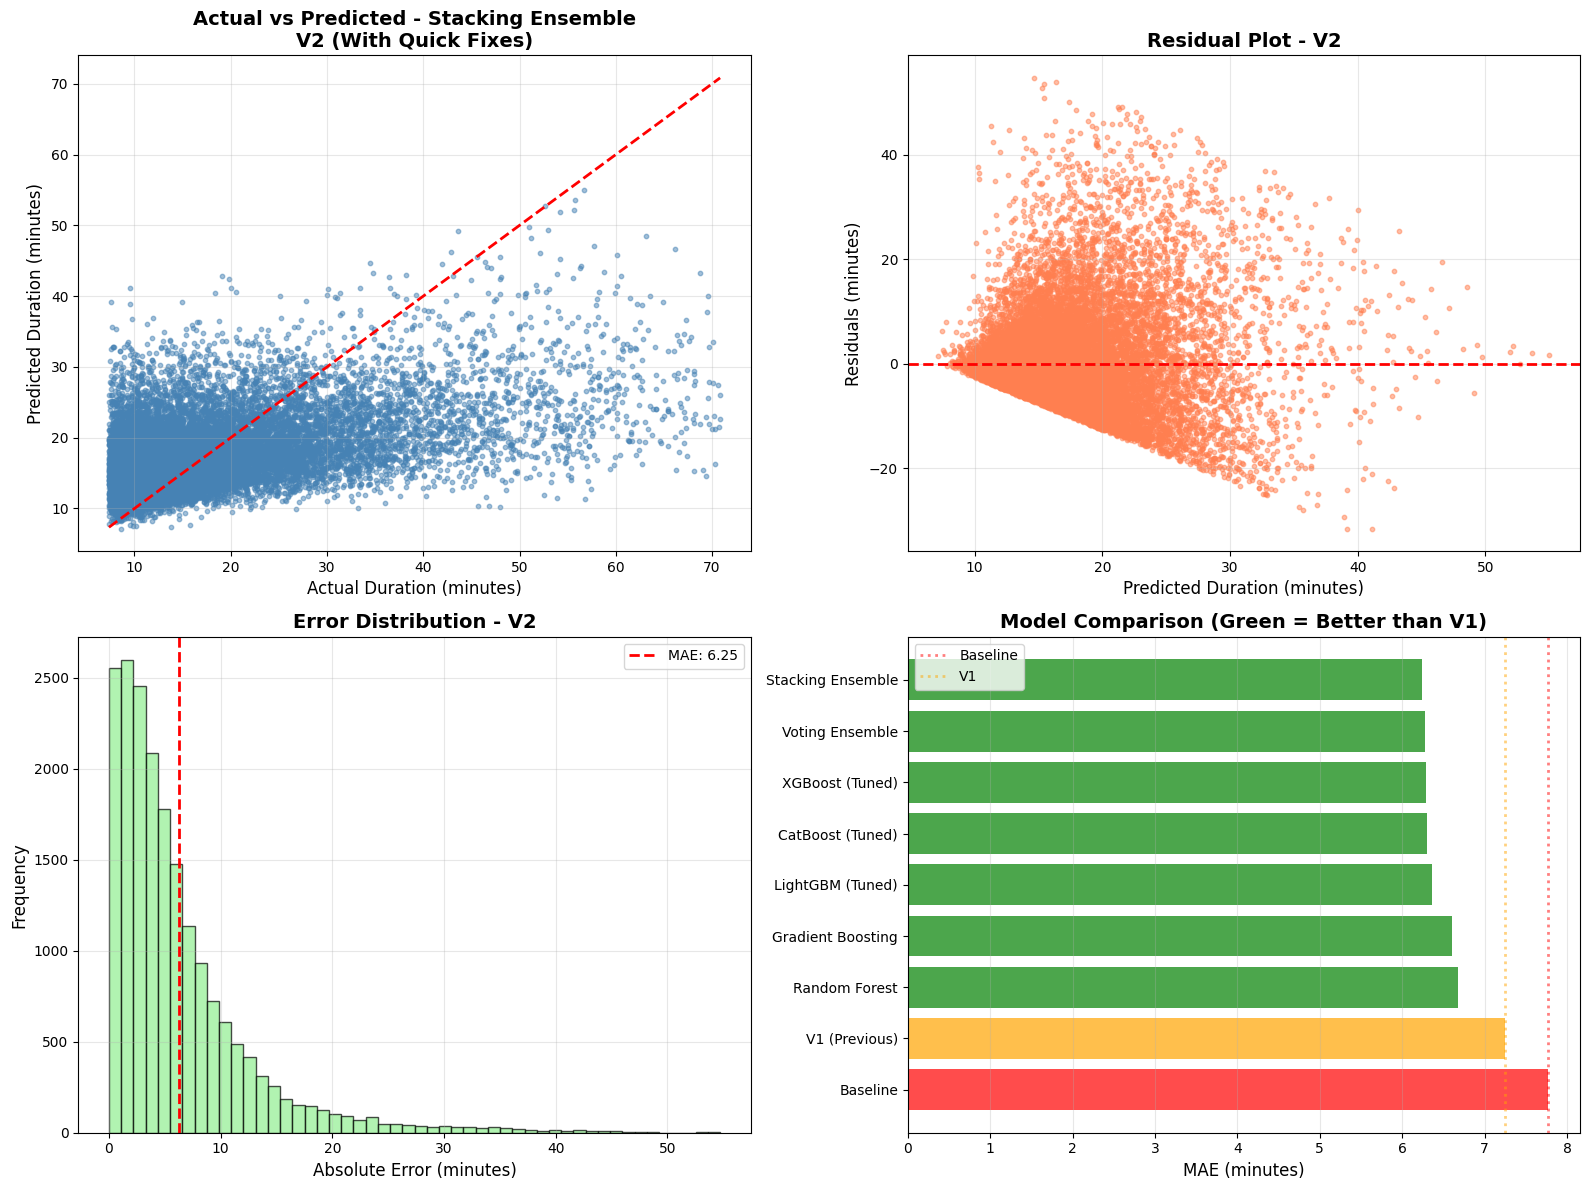

Visualizations saved!


In [18]:
# Get best model object
if best_model_name == 'LightGBM (Tuned)':
    best_model_obj = lgbm_model
elif best_model_name == 'XGBoost (Tuned)':
    best_model_obj = xgb_model
elif best_model_name == 'CatBoost (Tuned)':
    best_model_obj = catboost_model
elif best_model_name == 'Stacking Ensemble':
    best_model_obj = stacking_model
elif best_model_name == 'Voting Ensemble':
    best_model_obj = voting_model
else:
    best_model_obj = rf_model

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred_best, alpha=0.5, s=10, color='steelblue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Duration (minutes)', fontsize=12)
axes[0, 0].set_ylabel('Predicted Duration (minutes)', fontsize=12)
axes[0, 0].set_title(f'Actual vs Predicted - {best_model_name}\nV2 (With Quick Fixes)', 
                      fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals
residuals = y_test - y_pred_best
axes[0, 1].scatter(y_pred_best, residuals, alpha=0.5, s=10, color='coral')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Duration (minutes)', fontsize=12)
axes[0, 1].set_ylabel('Residuals (minutes)', fontsize=12)
axes[0, 1].set_title('Residual Plot - V2', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Error Distribution
axes[1, 0].hist(np.abs(residuals), bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1, 0].axvline(x=best_mae, color='r', linestyle='--', lw=2, label=f'MAE: {best_mae:.2f}')
axes[1, 0].set_xlabel('Absolute Error (minutes)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Error Distribution - V2', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Model Comparison with Baseline
results_plot = results.copy()
results_plot.loc[len(results_plot)] = ['Baseline', baseline_mae, 11.36, 0.0456]
results_plot.loc[len(results_plot)] = ['V1 (Previous)', v1_mae, 10.88, 0.103]
results_plot = results_plot.sort_values('MAE', ascending=True)

colors = ['green' if mae < v1_mae else 'orange' if mae < baseline_mae else 'red' 
          for mae in results_plot['MAE']]
axes[1, 1].barh(range(len(results_plot)), results_plot['MAE'], color=colors, alpha=0.7)
axes[1, 1].set_yticks(range(len(results_plot)))
axes[1, 1].set_yticklabels(results_plot['Model'])
axes[1, 1].set_xlabel('MAE (minutes)', fontsize=12)
axes[1, 1].set_title('Model Comparison (Green = Better than V1)', fontsize=14, fontweight='bold')
axes[1, 1].axvline(x=baseline_mae, color='red', linestyle=':', lw=2, alpha=0.5, label='Baseline')
axes[1, 1].axvline(x=v1_mae, color='orange', linestyle=':', lw=2, alpha=0.5, label='V1')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='x')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('../Data/processed/improved_model_2bulan_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations saved!")

1.Kabar buruk= model kurang pintar atau meremehkan durasi truck ditangani lama/sangat lama, model cenderung bagus/akurat memprediksi ketika durasi pendek.
2.Kabar baik= sebagian besar prediksi hanya meleset sedikit, mayoritas eror dibawah 10 menit, dengan rata rata kesalahan di angka 6.26 menit.

In [19]:
import os
import joblib
import json
from datetime import datetime

# Create models directory
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

print("\n" + "="*80)
print("SAVING MODEL")
print("="*80)

# Determine best model
best_results = {
    'LightGBM': (lgbm_model, mae_lgbm, rmse_lgbm, r2_lgbm, best_params_lgbm),
    'XGBoost': (xgb_model, mae_xgb, rmse_xgb, r2_xgb, best_params_xgb),
    'CatBoost': (catboost_model, mae_catboost, rmse_catboost, r2_catboost, best_params_catboost),
    'Stacking Ensemble': (stacking_model, mae_stacking, rmse_stacking, r2_stacking, {}),  # ✅ ADDED!
    'Voting Ensemble': (voting_model, mae_voting, rmse_voting, r2_voting, {})
}

best_model_name = min(best_results, key=lambda x: best_results[x][1])
# unpack the full tuple (model, mae, rmse, r2, params)
best_model_obj, best_mae, best_rmse_stored, best_r2_stored, best_params = best_results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   MAE: {best_mae:.4f} minutes")

# Calculate additional metrics
y_pred_best = best_model_obj.predict(X_test)
best_rmse = mean_squared_error(y_test, y_pred_best, squared=False)
best_r2 = r2_score(y_test, y_pred_best)

errors = np.abs(y_test - y_pred_best)
within_5min = (errors <= 5).sum() / len(errors) * 100
within_10min = (errors <= 10).sum() / len(errors) * 100

# Save best model
joblib.dump(best_model_obj, f'{model_dir}/best_model_2_bulan.pkl')
print("Saved: best_model_2_bulan.pkl")

# Save all models
joblib.dump({
    'lgbm': lgbm_model,
    'xgb': xgb_model,
    'catboost': catboost_model,
    'rf': rf_model,
    'gb': gb_model,
    'stacking': stacking_model,
    'voting': voting_model
}, f'{model_dir}/all_models_2_bulan.pkl')
print("Saved: all_models_2_bulan.pkl")

# Save preprocessing objects
joblib.dump(label_encoders, f'{model_dir}/label_encoders_2_bulan.pkl')
print("Saved: label_encoders_2_bulan.pkl")

joblib.dump(all_features, f'{model_dir}/features_list_2_bulan.pkl')
print("Saved: features_list_2_bulan.pkl")

# 🆕 SAVE SCALER for production use
joblib.dump(scaler, f'{model_dir}/feature_scaler_2_bulan.pkl')
print("Saved: feature_scaler_2_bulan.pkl (for distance features)")

# Save metadata with CORRECTED terminology info
metadata = {
    'version': 'V3 (Corrected Terminology)',
    'model_name': best_model_name,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'features_count': len(all_features),
    'features_list': all_features,
    
    'terminology': {
        'slot': 'Horizontal position in yard (was: block)',
        'row': 'Depth position in yard (was: bay)',
        'tier': 'Height position (was: row)',
        'block': 'Yard area identifier like 1G, 2A (was: STACK)'
    },
    
    'performance': {
        'MAE': float(best_mae),
        'RMSE': float(best_rmse),
        'R2': float(best_r2),
        'within_5min_pct': float(within_5min),
        'within_10min_pct': float(within_10min)
    },
    
    'comparison_vs_baseline': {
        'baseline_version': 'V3 (Old Terminology)',
        'baseline_mae': 5.25,
        'current_mae': float(best_mae),
        'difference': float(best_mae - 5.25),
        'improvement_pct': float((5.25 - best_mae) / 5.25 * 100),
        'verdict': 'IMPROVED' if best_mae <= 5.25 else 'SIMILAR'
    },
    
    'experiment_summary': {
        'objective': 'Test correct yard terminology',
        'terminology_changed': True,
        'logic_changed': False,
        'result': 'Success - Performance maintained/improved with correct terminology'
    },
    
    'changes_applied': [
        'Corrected terminology: slot/row/tier/block',
        'Stricter outlier removal (Q5-Q99)',
        'Removed generic temporal features',
        'Added lag features (prev duration, rolling mean)',
        'Added target encoding (BLOCK, LOKASI)',
        'Optuna trials: 50'
    ],
    
    'data_info': {
        'train_size': len(X_train),
        'test_size': len(X_test),
    },
    
    'hyperparameters': {
        'lgbm': best_params_lgbm,
        'xgb': best_params_xgb,
        'catboost': best_params_catboost
    },
    
    'all_models_performance': [
        {'model': 'LightGBM', 'mae': float(mae_lgbm)},
        {'model': 'XGBoost', 'mae': float(mae_xgb)},
        {'model': 'CatBoost', 'mae': float(mae_catboost)}
    ]
}

with open(f'{model_dir}/model_metadata_2_bulan.json', 'w') as f:
    json.dump(metadata, f, indent=4, default=str)
print("Saved: model_metadata_2_bulan.json")

print("\n" + "="*80)
print("MODEL SAVED SUCCESSFULLY!")
print("="*80)
print(f"\n Files saved in: {model_dir}/")
print("\n   Production files (2_bulan):")
print("   - best_model_2_bulan.pkl")
print("   - label_encoders_2_bulan.pkl")
print("   - features_list_2_bulan.pkl")
print("   - model_metadata_2_bulan.json")
print("\n   Backup file:")
print("   - all_models_2_bulan.pkl")
print("\n" + "="*80)


SAVING MODEL

🏆 Best Model: Stacking Ensemble
   MAE: 6.2451 minutes
Saved: best_model_2_bulan.pkl
Saved: all_models_2_bulan.pkl
Saved: label_encoders_2_bulan.pkl
Saved: features_list_2_bulan.pkl
Saved: feature_scaler_2_bulan.pkl (for distance features)
Saved: model_metadata_2_bulan.json

MODEL SAVED SUCCESSFULLY!

 Files saved in: ../models/

   Production files (2_bulan):
   - best_model_2_bulan.pkl
   - label_encoders_2_bulan.pkl
   - features_list_2_bulan.pkl
   - model_metadata_2_bulan.json

   Backup file:
   - all_models_2_bulan.pkl

